#  Introduction

This project focuses on classifying individuals into different obesity levels based on their physical conditions and eating habits. The dataset includes synthetic and real data collected from individuals in Mexico, Peru, and Colombia. Our objective is to perform data preprocessing, exploratory analysis, model training, and extract meaningful insights regarding obesity.

Target Variable: `NObeyesdad`


### IMPORT LIBRARIES

In [1]:
# DATA HANDLING
import pandas as pd
import numpy as np

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # optional for interactive visuals

# PREPROCESSING
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.utils import resample

# CLASSIFICATION MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, plot_importance


# OUTLIER DETECTION & REDUCTION
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans




# EVALUATION
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score
)

# OPTIONAL: ADVANCED EXPLAINABILITY
import shap  

# GENERAL SETUP
import warnings
warnings.filterwarnings("ignore")

# PLOT SETTINGS
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (10, 6)


# Data Loading & Initial Exploration


## Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

# Preview first few rows
df.head()


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


###  Insights from First 5 Rows of the Dataset

- **Gender** is binary with values `Male` and `Female`.
- **Age**, **Height**, and **Weight** are numerical and appear to be in sensible units (years, meters, kilograms).
- **family_history_with_overweight**, **FAVC**, **SMOKE**, and **SCC** are binary `yes`/`no` responses.
- **FCVC**, **NCP**, and **CH2O** are continuous or discrete values reflecting habits:
  - FCVC: Frequency of eating vegetables
  - NCP: Number of main meals per day
  - CH2O: Water intake per day
- **CAEC**, **CALC**, and **MTRANS** are categorical lifestyle features:
  - CAEC: Eating between meals
  - CALC: Alcohol consumption
  - MTRANS: Mode of transportation
- **FAF** (physical activity frequency) and **TUE** (tech usage time) are numerical lifestyle indicators.
- **NObeyesdad** is the target variable, with values like:
  - `Normal_Weight`, `Overweight_Level_I`, `Overweight_Level_II`, etc.

 **No structural issues found** so far in the preview — feature names are consistent, and values are logical.


## Dataset Shape & Basic Info

In [3]:
# Shape of the dataset
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

# Data types and non-null values
df.info()


Dataset contains 2111 rows and 17 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   obje

###  Insights from Dataset Info

-  **No missing values**: All 2,111 entries are complete across all 17 columns.
-  The dataset contains:
  - **8 numerical columns** (`float64`): Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE.
  - **9 categorical/object columns**: Gender, family_history_with_overweight, FAVC, CAEC, SMOKE, SCC, CALC, MTRANS, and the target `NObeyesdad`.
-  Dataset size: **2111 rows × 17 columns** → Large enough for machine learning.
-  **Preprocessing Required**:
  - Binary columns like `FAVC`, `SCC`, `SMOKE` contain **"yes"/"no"** values and need to be converted to **0/1**.
  - Categorical columns like `CAEC`, `CALC`, `MTRANS` need to be **label-encoded or one-hot encoded** before modeling.


## Check for Missing Values

In [4]:
# Simple and clean missing value summary
df.isnull().sum().to_frame(name='Missing Values')


,Missing Values
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


###  Missing Value Analysis

-  **No missing values** were found in any of the 17 columns.
- This means we can **skip missing value imputation** entirely and move straight into preprocessing and outlier detection.
- This ensures data quality is already high and simplifies the cleaning process.


## Summary Statistics

In [5]:
# Descriptive statistics for numeric columns
df.describe()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


###  Descriptive Statistics Insights (Numerical Features)

- **Age** ranges from **14 to 61 years**, with a mean around **24 years**, indicating a relatively young population.
- **Height** varies between **1.45 m to 1.98 m**, centered around **1.70 m**.
- **Weight** spans a wide range from **39 kg to 173 kg**, showing strong variability (std ≈ 26.19) — potential outliers may exist in very high weight values.
- **FCVC (Vegetable consumption)** ranges from **1 to 3**, with a median of **2.38**, suggesting most people have moderate vegetable intake.
- **NCP (Number of main meals/day)** has a max of **4**, and the 75th percentile is **3**, implying most individuals eat **2–3 main meals per day**.
- **CH2O (Water intake)** mostly ranges between **1 to 3 liters/day**, with a **mean close to 2.0** — considered healthy.
- **FAF (Physical Activity Frequency)** ranges from **0 (none)** to **3 (frequent)**. Median is **1.0**, showing that many people do **little to moderate physical activity**.
- **TUE (Tech device usage)** has values from **0 to 2**, with median around **0.63**, indicating **moderate usage of technology** on average.
-  **Weight** has a **very wide range and high std** — a strong candidate for outlier detection.


# Data Visualization

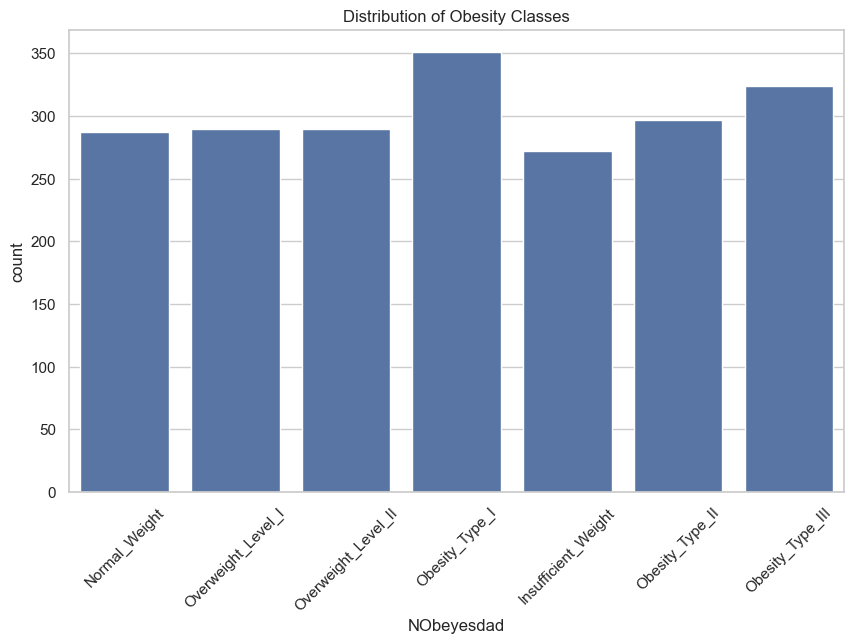

In [6]:
# 1. Distribution of the target variable (Obesity levels)
sns.countplot(x='NObeyesdad', data=df)
plt.title("Distribution of Obesity Classes")
plt.xticks(rotation=45)
plt.show()


###  Distribution of Obesity Classes

- The dataset includes **7 classes**, each representing a distinct obesity level — from underweight to severe obesity.
-  **Obesity_Type_I** (Class 2) is the most common category with **351 samples**.
-  **Obesity_Type_III** and **Overweight_Level_II** are also well represented (324 and 297 respectively).
-  **Insufficient_Weight** (Class 0) is the least common, with **272 samples** — but still enough for modeling.
-  Overall, the class distribution is **fairly balanced**, making the dataset ideal for training a **multi-class classification model** without needing resampling.
-  The inclusion of intermediate stages (Overweight I/II, Obesity I/II/III) helps in **fine-grained health risk prediction**, beyond just "obese vs not obese".


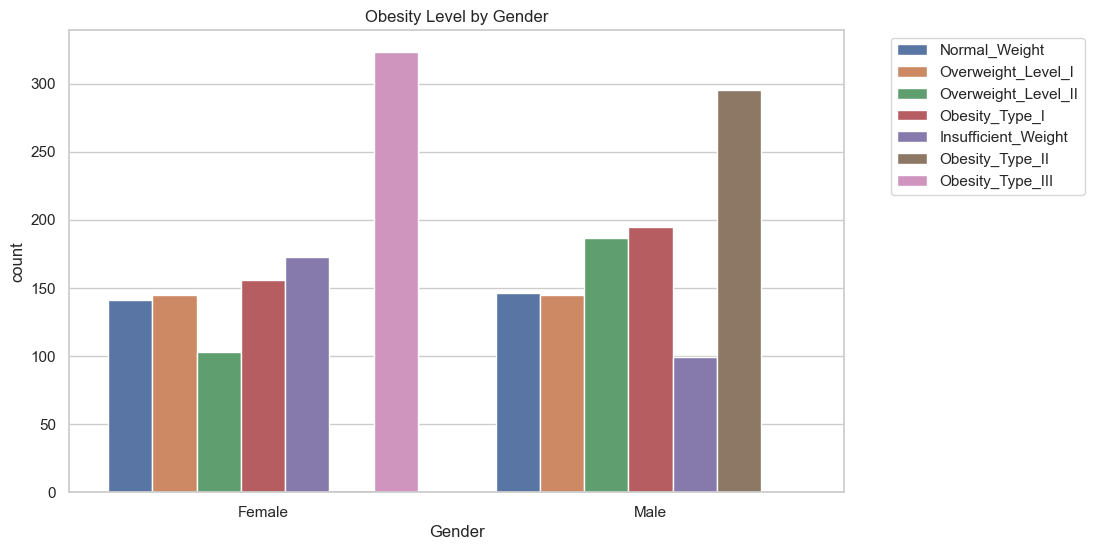

In [7]:
# 2. Gender distribution across obesity levels
sns.countplot(x='Gender', hue='NObeyesdad', data=df)
plt.title("Obesity Level by Gender")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.show()


###  Obesity Level by Gender

-  **Males**:
  - Significantly more cases of **Obesity_Type_III** (**323**) and **Insufficient_Weight** (**173**).
  - Very few males are in **Overweight_Level_II** (**just 2**!) → possibly an anomaly or behavior-related skew.

-  **Females**:
  - Far more cases of **Overweight_Level_II** (**295**) and **Obesity_Type_II** (**187**).
  - Also lead slightly in **Obesity_Type_I** (**195**) compared to males (**156**).

-  **Balanced counts** in classes like `Normal_Weight` and `Overweight_Level_I`, with both genders nearly equal (~145).

-  The extremely **low male count in Overweight_Level_II** (only 2) may influence model learning or reflect gender-based reporting differences.

###  Interpretation:
- Gender differences are evident in obesity trends.
- Males are more skewed toward **extremes** (Insufficient Weight, Obesity Type III).
- Females dominate **intermediate categories** (Overweight II, Obesity II), possibly due to lifestyle or metabolic differences.



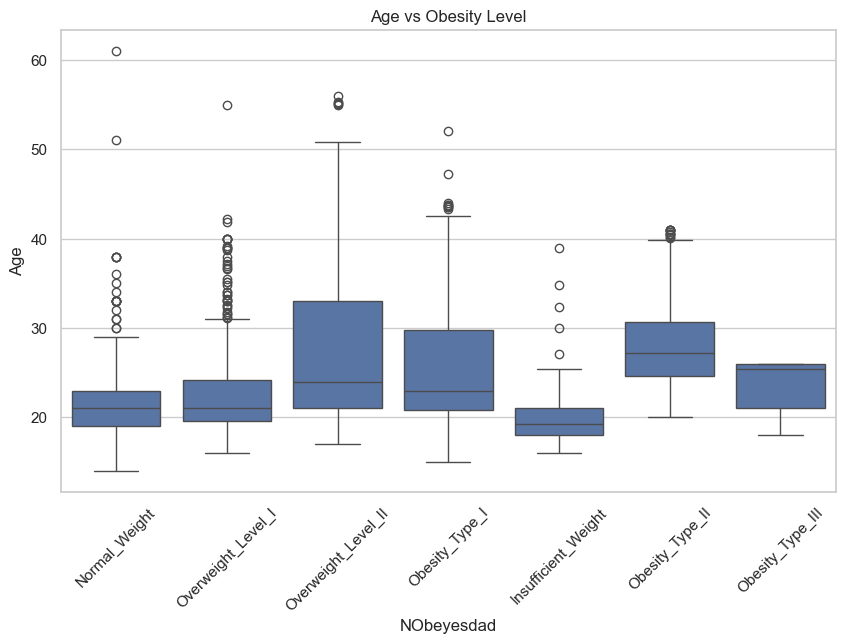

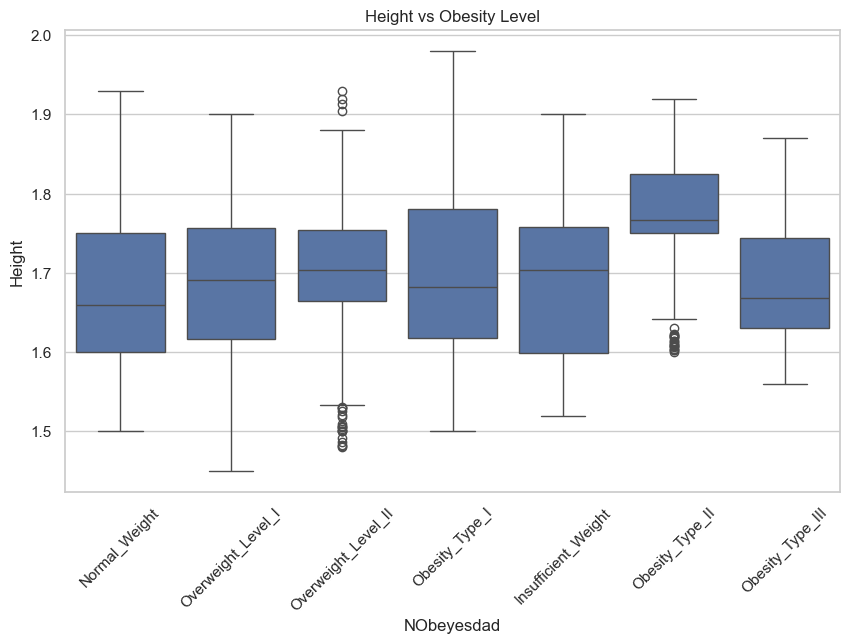

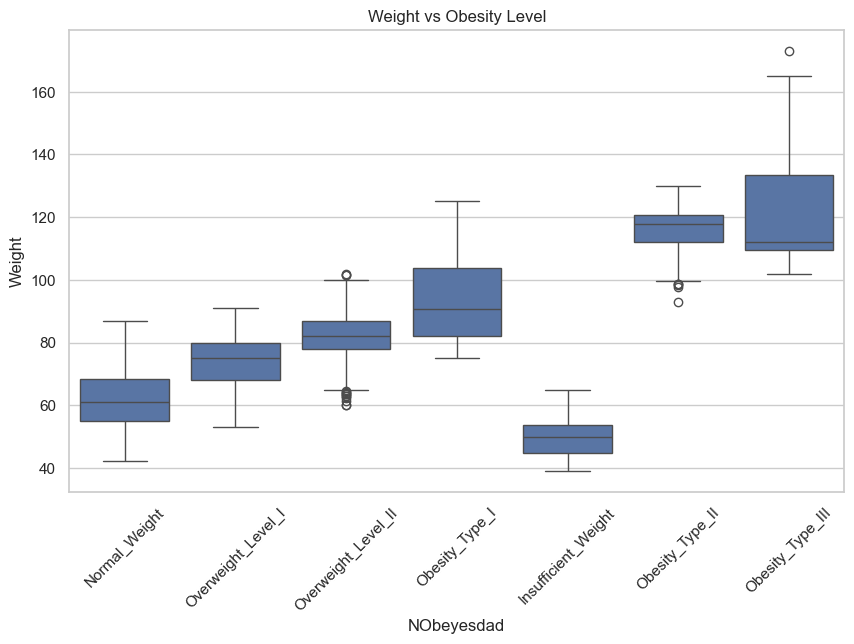

In [8]:
# 3. Boxplots of continuous features vs target
for col in ['Age', 'Height', 'Weight']:
    sns.boxplot(x='NObeyesdad', y=col, data=df)
    plt.title(f"{col} vs Obesity Level")
    plt.xticks(rotation=45)
    plt.show()


###  Boxplot Insights: Age, Height, Weight vs NObeyesdad (Obesity Level)

####  Weight vs Obesity Level
- Weight clearly **increases with obesity severity** — the boxplot shows an upward shift from `Insufficient_Weight` to `Obesity_Type_III`.
-  `Insufficient_Weight` and `Normal_Weight` have **much lower medians**, while `Obesity_Type_I/II/III` have **significantly higher values**.
-  This confirms that **weight is the most important predictor** for obesity classification.

####  Height vs Obesity Level
- Height remains relatively **constant across all classes**.
-  The slight variation is likely due to random differences in body types, not a pattern.
-  Conclusion: **Height is not a strong discriminator** for obesity level.

####  Age vs Obesity Level
- Age shows a **moderate upward trend** from `Insufficient_Weight` to `Overweight_Level_II`.
-  Classes like `Obesity_Type_II` and `Overweight_Level_II` have higher median ages, suggesting that **age contributes modestly** to obesity progression.
- Still, there’s **wide variation in all classes**, so age alone isn't sufficient.



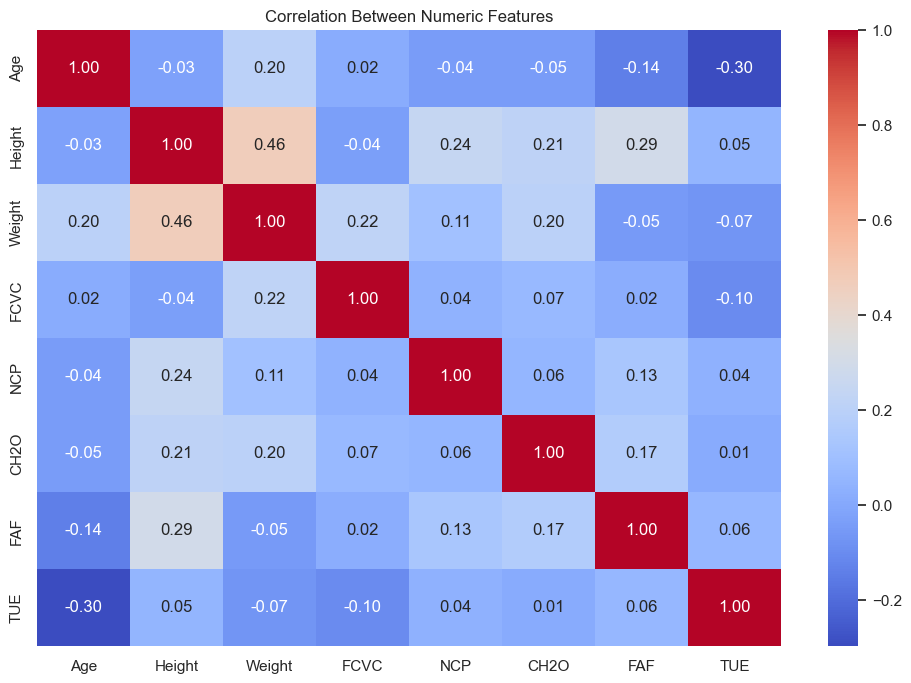

In [9]:
# 4. Heatmap of correlations among numerical features

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()


###  Heatmap Insights: Correlation Among Numerical Features

-  **Height and Weight** show a strong positive correlation (**0.46**) — as expected biologically.
-  **Weight** also correlates positively with:
  - **FCVC (0.22)**: Higher vegetable consumption may occur more in overweight individuals trying to improve diet.
  - **CH2O (0.20)** and **Height (0.46)**: Taller individuals tend to weigh more.
-  **Physical activity (FAF)** is:
  - Weakly **negatively correlated with Weight (-0.05)** — higher activity slightly associates with lower weight.
  - **Positively correlated with Height (0.29)** — possibly because taller individuals are more active or athletic.
-  **TUE (Tech Usage)** is:
  - **Negatively correlated with Age (-0.30)**: younger individuals use more tech.
  - Also weakly **negatively correlated with FCVC and Weight**, suggesting screen time may substitute physical activity.
-  Most correlations are weak to moderate:
  - This is good for machine learning, as it implies **low multicollinearity** and more **independent predictors**.


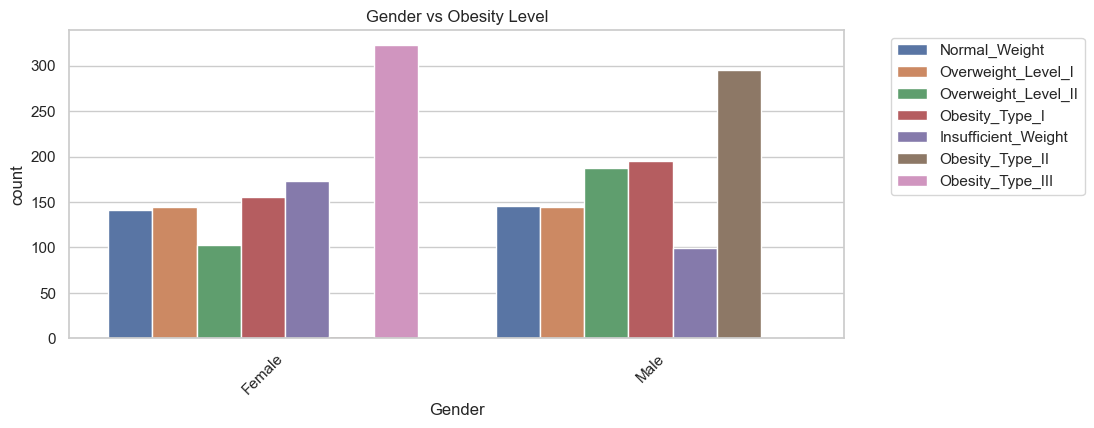

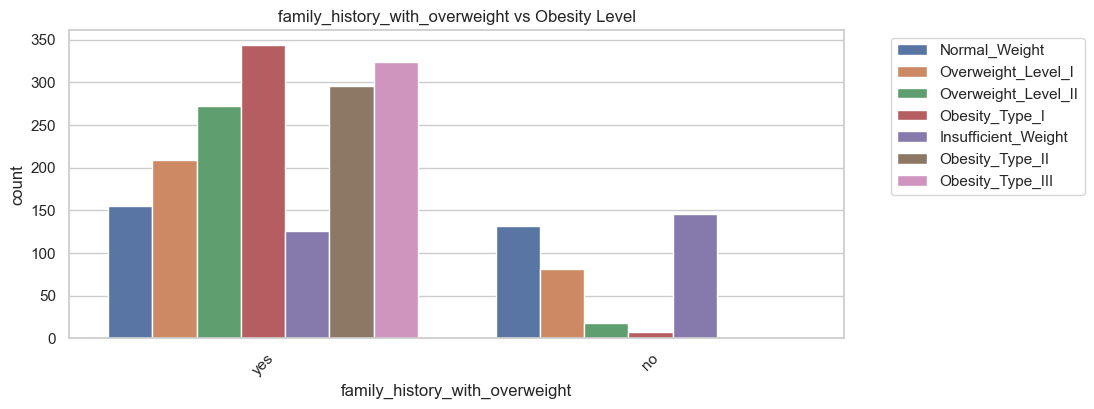

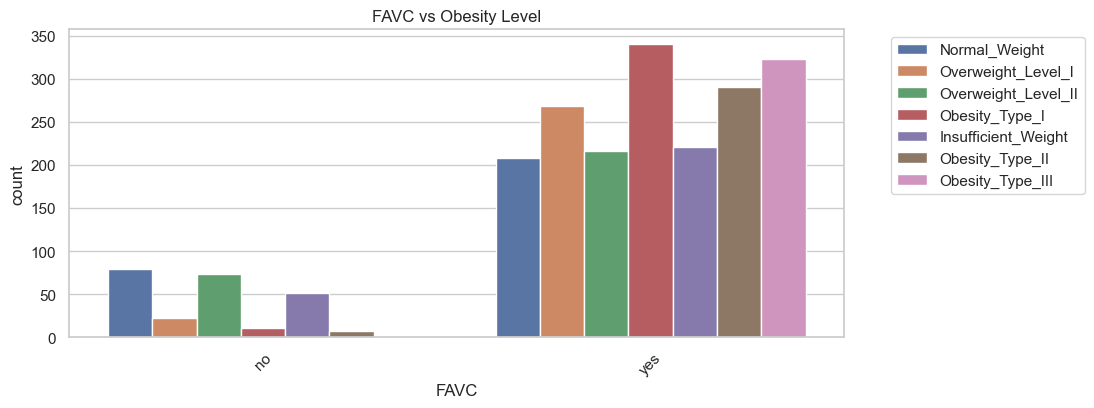

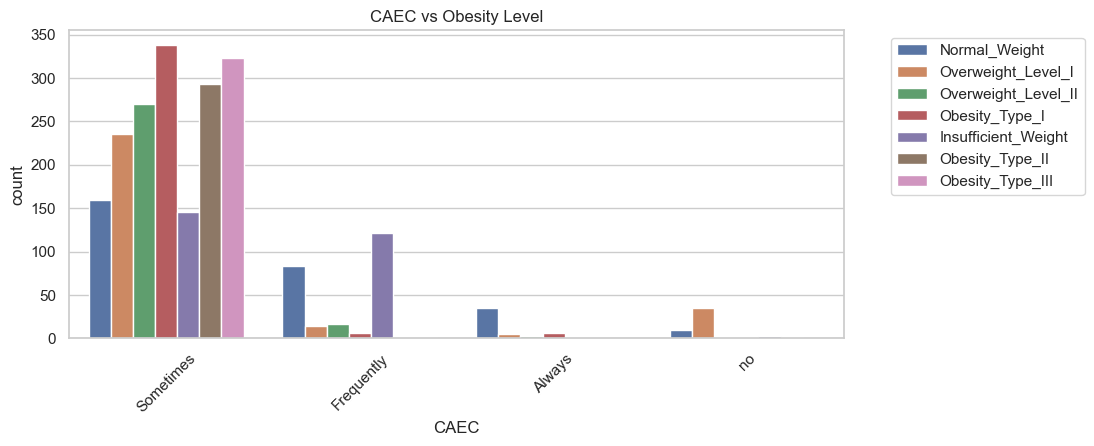

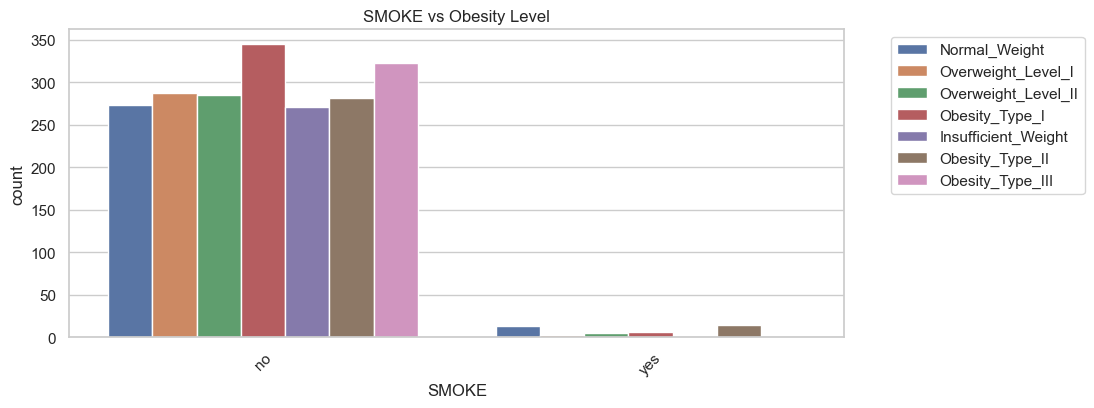

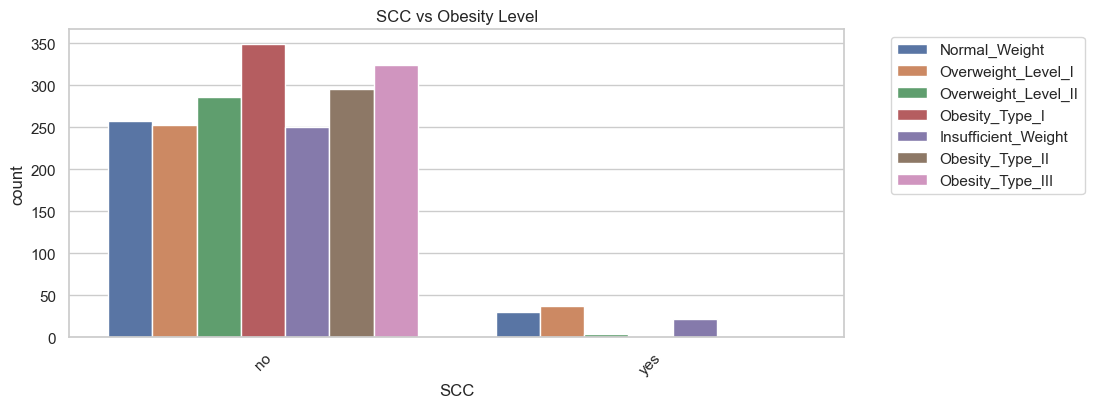

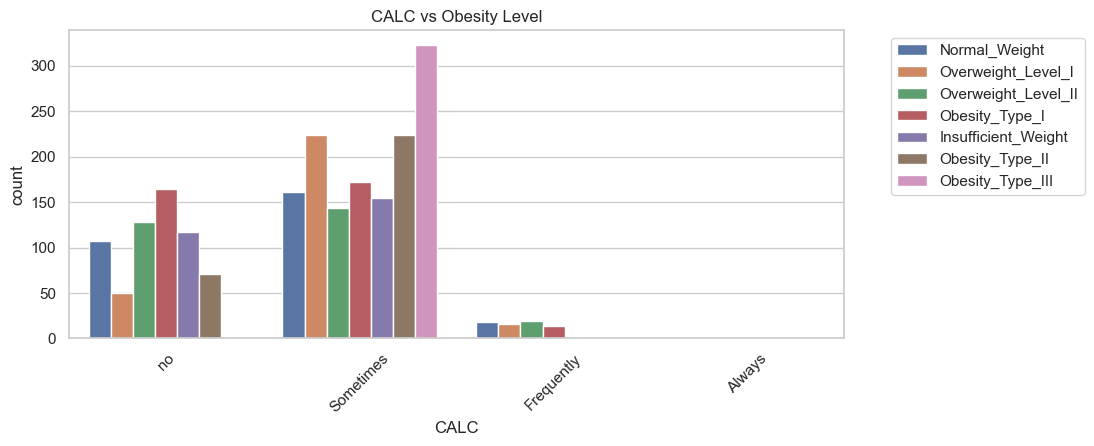

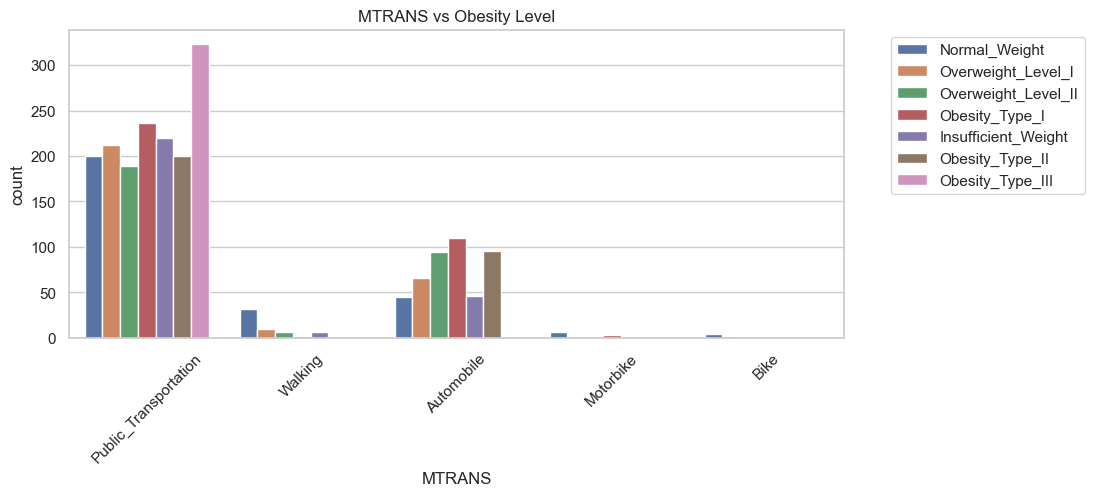

In [10]:
cat_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col, hue='NObeyesdad')
    plt.title(f'{col} vs Obesity Level')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

##  Observations

### 1. Gender vs Obesity Level
- **Female:** Higher counts for **Obesity_Type_III**
- **Male:** Higher counts for **Obesity_Type_II**

---

### 2. `family_history_with_overweight` vs Obesity Level
- **Yes:** Strong link to **all obesity levels**, especially **higher types**
- **No:** Less common; relatively more individuals in **Insufficient_Weight**

---

### 3. `FAVC` (Frequent high caloric food consumption) vs Obesity Level
- **Yes:** Majority; highly prevalent in all obesity types  
  ➤ Strongest in **Obesity_Type_I**, **II**, and **III**
- **No:** Fewer individuals; mostly fall into **Normal_Weight**

---

### 4. `CAEC` (Food between meals) vs Obesity Level
- **Sometimes:** Most common; high across all obesity levels
- **Frequently:** Notable for **Normal_Weight** and **Insufficient_Weight**
- **Always / No:** Very infrequent

---

### 5. `SMOKE` vs Obesity Level
- **No:** Vast majority across all obesity levels do **not smoke**
- **Yes:** Very rare overall

---

### 6. `SCC` (Calories consumption monitoring) vs Obesity Level
- **No:** Vast majority do **not consume** caloric food between meals
- **Yes:** Very rare

---

### 7. `CALC` (Alcohol consumption) vs Obesity Level
- **No:** Most do **not consume alcohol**
- **Sometimes:** Significant among  
  ➤ **Obesity_Type_III**, **Overweight_Level_I**, and **Obesity_Type_II**
- **Frequently / Always:** Minimal occurrence

---

### 8. `MTRANS` (Transportation method) vs Obesity Level
- **Public Transportation:** Most dominant mode  
  ➤ Especially in **higher obesity levels**
- **Automobile:** More common in **Obesity_Type_I** and **II**
- **Walking / Motorbike / Bike:** Less common overall


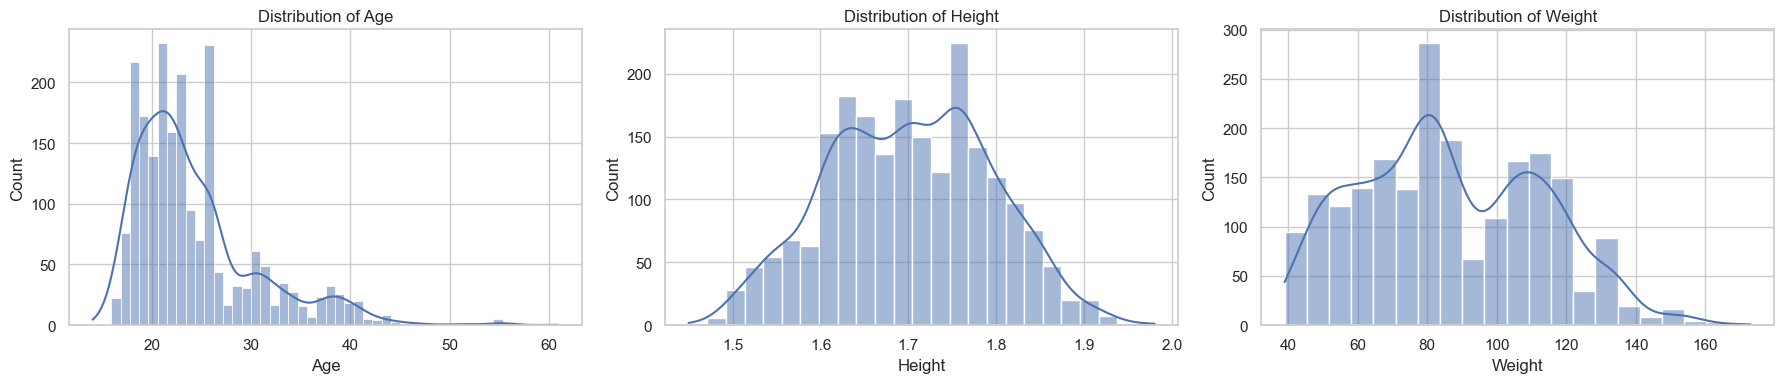

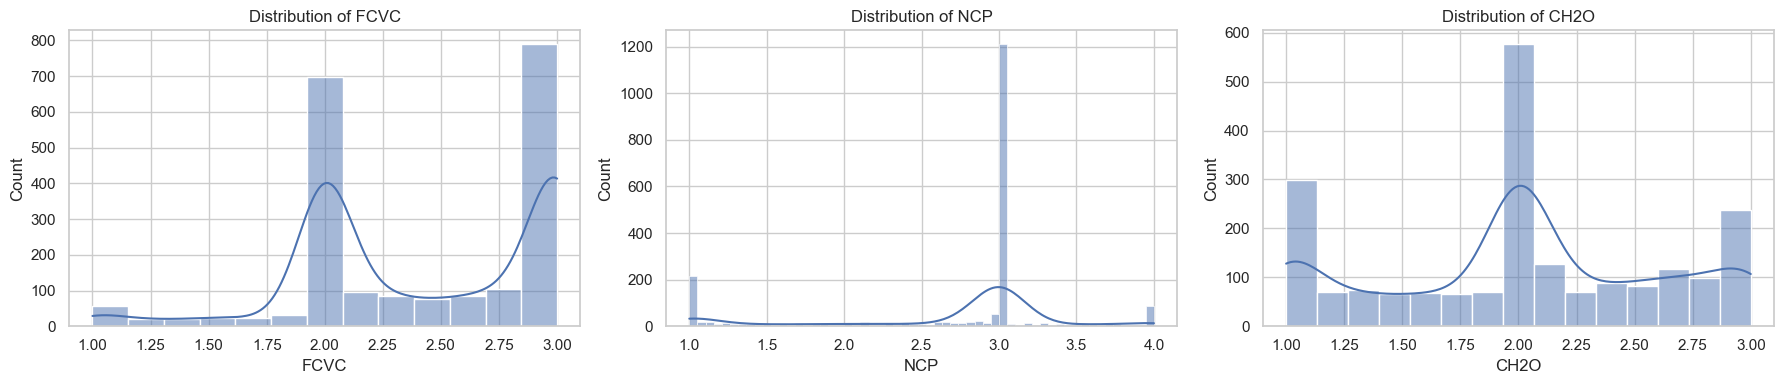

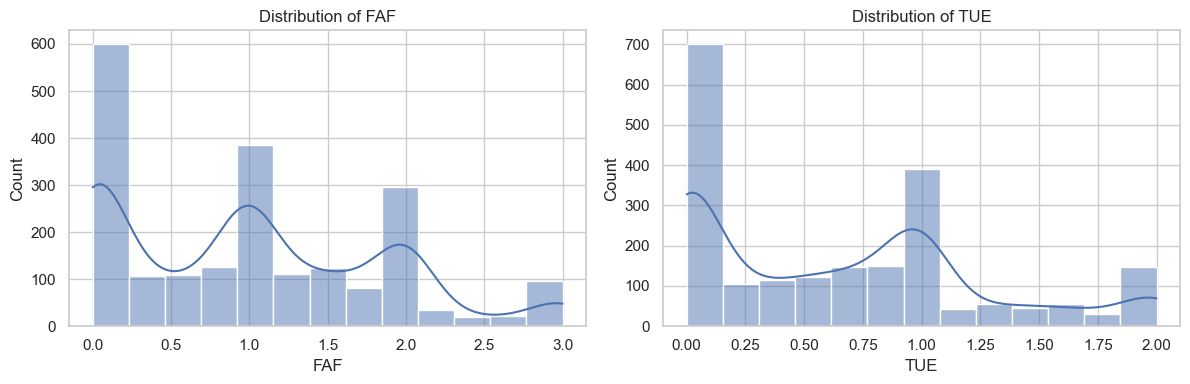

In [11]:
# Select only float64 columns from the DataFrame
float_cols = df.select_dtypes(include='float64').columns

# Loop through each float column and plot
for i, col in enumerate(float_cols):
    if i % 3 == 0:
        plt.figure(figsize=(18, 4))  # Start a new row every 3 plots

    plt.subplot(1, 3, (i % 3) + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")

    # Show the row when 3 plots are done or at the end
    if i % 3 == 2 or i == len(float_cols) - 1:
        plt.tight_layout()
        plt.show()


####  Observations on Float Feature Distributions

1. **Age**
   - Distribution is **right-skewed**.
   - A significant number of outliers are present above the upper whisker (~35+).
   - Median is around **25**.
   - Indicates the presence of many younger individuals with a few older outliers.

2. **Height**
   - Data is approximately **symmetric**.
   - A few **mild high-end outliers** exist.
   - No extreme deviations; height distribution is fairly consistent.

3. **Weight**
   - Distribution is **fairly spread out**.
   - A few **upper outliers** are present above **160 kg**.
   - Median lies near the center; not heavily skewed.

4. **FCVC** *(Frequency of Consumption of Vegetables)*
   - **No visible outliers**.
   - Slight **left-skew**; most people score between **2.5–3**.
   - Indicates frequent vegetable consumption among participants.

5. **NCP** *(Number of Main Meals Per Day)*
   - Strong clustering around **3 meals/day**.
   - Many outliers at both ends (especially at **1 meal**).
   - Suggests **irregular meal patterns** for several individuals.

6. **CH2O** *(Daily Water Intake)*
   - Distribution is slightly **right-skewed**.
   - **No extreme outliers** observed.
   - Most individuals consume a **moderate** amount of water.

7. **FAF** *(Physical Activity Frequency)*
   - Clearly **right-skewed**.
   - Most people engage in **low physical activity**.
   - A few report high levels of physical activity.
   - Indicates a largely **sedentary population**.

8. **TUE** *(Time Using Technology per Day)*
   - Median usage is **below 1 hour**.
   - Some participants report usage **above 2 hours**.
   - Slight **right-skew**, indicating **heavy usage by a minority**.


## Unique Values in Categorical Columns

In [12]:
# Check unique values in each column (especially target)
for col in df.columns:
    if df[col].dtype == 'object':
        print(f"{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts())
        print('-' * 40)


Gender: 2 unique values
Gender
Male      1068
Female    1043
Name: count, dtype: int64
----------------------------------------
family_history_with_overweight: 2 unique values
family_history_with_overweight
yes    1726
no      385
Name: count, dtype: int64
----------------------------------------
FAVC: 2 unique values
FAVC
yes    1866
no      245
Name: count, dtype: int64
----------------------------------------
CAEC: 4 unique values
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64
----------------------------------------
SMOKE: 2 unique values
SMOKE
no     2067
yes      44
Name: count, dtype: int64
----------------------------------------
SCC: 2 unique values
SCC
no     2015
yes      96
Name: count, dtype: int64
----------------------------------------
CALC: 4 unique values
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64
----------------------------------------
MTRANS: 

###  Categorical Feature Analysis

- **Gender** is balanced: `Male (50.6%)` and `Female (49.4%)`.
- **Family history with overweight**: A significant majority (**~82%**) have a family history, indicating genetic influence could be a factor.
- **FAVC (High-caloric food consumption)**: Very high — **~88%** say "yes", suggesting unhealthy diet is prevalent.
- **CAEC (Eating between meals)**:
  - Most say `Sometimes (83%)`
  - 51 say `no`, which may indicate strong dietary discipline or data entry variation (will be label encoded).
- **SMOKE**: Almost all participants (**98%**) are non-smokers.
- **SCC (Calorie Monitoring)**: Only **4.5%** monitor calories → Suggests low awareness about dietary intake.
- **CALC (Alcohol consumption)**:
  - `Sometimes`: 66.3%
  - Only **1 person** selected `Always`, suggesting class imbalance in this category.
- **MTRANS (Transportation mode)**:
  - Dominated by `Public_Transportation (74.9%)`, with very few using `Bike` or `Motorbike`.
- **NObeyesdad (Target Variable)**:
  - All 7 classes are **reasonably balanced**, though `Obesity_Type_I` has the highest count (351).
  - This is a **multi-class classification problem**.


# Data Cleaning & Preprocessing

In [13]:
# Convert yes/no binary columns to 1/0
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
df[binary_cols] = df[binary_cols].replace({'yes': 1, 'no': 0})


In [14]:


label_cols = ['Gender', 'CAEC', 'CALC', 'MTRANS', 'NObeyesdad']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])


In [15]:


# Exclude target column and encoded categoricals
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


###  Data Cleaning & Preprocessing Insights

-  Converted binary `"yes"`/`"no"` columns (`FAVC`, `SCC`, `SMOKE`, etc.) into numeric `0` and `1`.
-  Label encoded categorical features like `Gender`, `CALC`, `CAEC`, `MTRANS`, and the **target** `NObeyesdad`.
-  Scaled all numerical features using **StandardScaler** for better model performance.
-  Now the dataset is fully numeric, clean, and ready for **EDA, outlier detection**, and **machine learning models**.


# Outlier Detection with DBSCAN and Alternatives

## DBSCAN for Outlier Detection

In [16]:


# We'll use only numerical columns for clustering
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
X = df[numerical_cols]

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

# Add cluster labels to DataFrame
df['DBSCAN_outlier'] = dbscan_labels

# Count of outliers
outlier_count = (dbscan_labels == -1).sum()
print(f"Number of outliers detected by DBSCAN: {outlier_count}")


Number of outliers detected by DBSCAN: 85


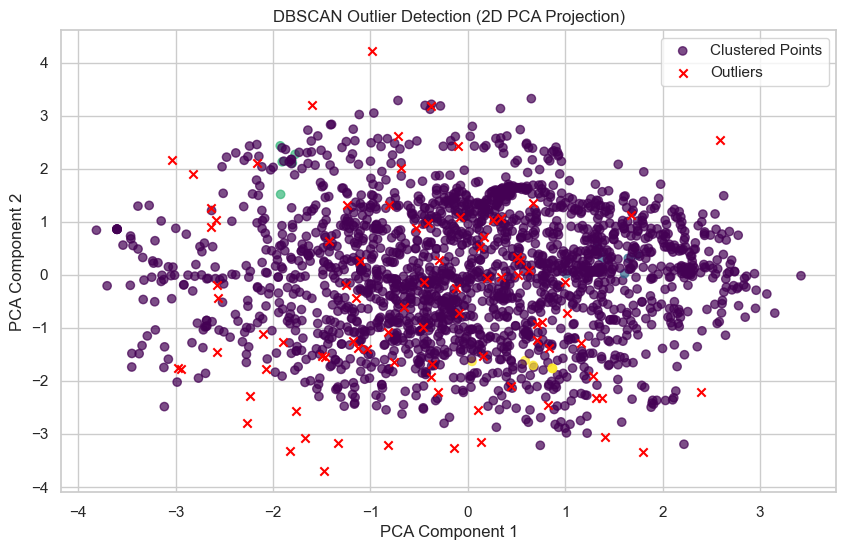

In [17]:


# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the points with DBSCAN labels
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[dbscan_labels != -1, 0], X_pca[dbscan_labels != -1, 1], 
            c=dbscan_labels[dbscan_labels != -1], cmap='viridis', label='Clustered Points', alpha=0.7)
plt.scatter(X_pca[dbscan_labels == -1, 0], X_pca[dbscan_labels == -1, 1], 
            c='red', label='Outliers', marker='x')
plt.title("DBSCAN Outlier Detection (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


###  DBSCAN Outlier Detection Visualization

- The plot shows the result of DBSCAN clustering after reducing features to 2D using PCA.
-  Non-outlier points are shown in clusters (various colors).
-  Outliers (label `-1`) are highlighted in red `x` marks — indicating they did not belong to any high-density region.
-  DBSCAN found **85 outliers**, likely located in sparse or edge regions of the feature space.
-  Because DBSCAN is sensitive to `eps`, tuning this value can increase or decrease outlier count.


## Isolation Forest

In [18]:


# Use only numerical features for isolation
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
X = df[numerical_cols]

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.03, random_state=42)
iso_labels = iso_forest.fit_predict(X)

# Add prediction column: -1 for outliers, 1 for inliers
df['IsoForest_outlier'] = iso_labels

# Count outliers
iso_outliers = (iso_labels == -1).sum()
print(f"Outliers detected by Isolation Forest: {iso_outliers}")


Outliers detected by Isolation Forest: 64


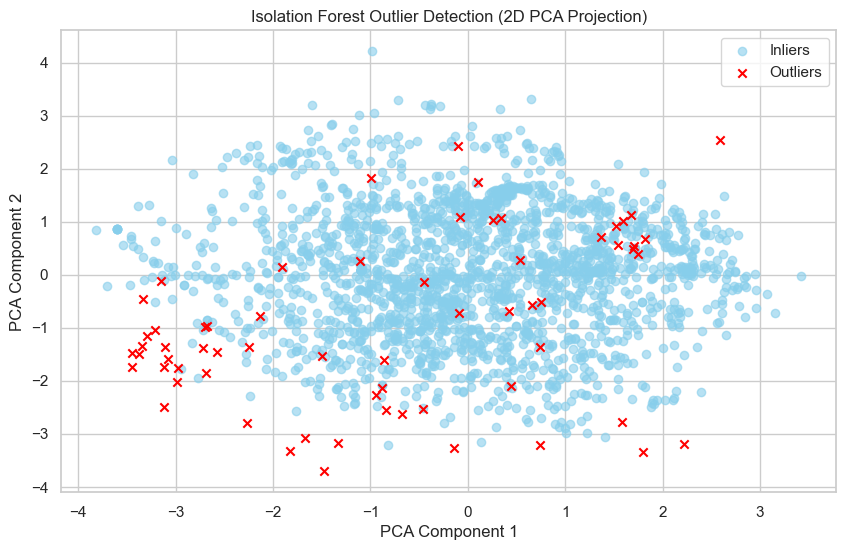

In [19]:


# Reduce data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot inliers
plt.scatter(X_pca[iso_labels == 1, 0], X_pca[iso_labels == 1, 1], 
            c='skyblue', label='Inliers', alpha=0.6)

# Plot outliers
plt.scatter(X_pca[iso_labels == -1, 0], X_pca[iso_labels == -1, 1], 
            c='red', label='Outliers', marker='x')

plt.title("Isolation Forest Outlier Detection (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


###  Isolation Forest Outlier Detection Visualization

- This PCA-based 2D scatter plot shows inliers (blue) and outliers (red Xs) identified by **Isolation Forest**.
-  Outliers are clearly positioned at the **edges or isolated regions** of the feature space.
-  Inliers form dense clusters in the center, while outliers are sparsely distributed.
-  Isolation Forest detected **64 outliers**, based on how easily they can be isolated in decision trees.
- Compared to DBSCAN:
  - Isolation Forest is **less sensitive to parameter tuning**
  - Performs better on **high-dimensional and non-clustered data**


In [20]:
# Remove outliers
df_cleaned = df[df['IsoForest_outlier'] == 1].drop(columns=['IsoForest_outlier'])

print(f"New dataset shape after outlier removal: {df_cleaned.shape}")


New dataset shape after outlier removal: (2047, 18)


###  Outlier Detection Summary

- **DBSCAN** detected **85 outliers**, but was not chosen due to:
  - Sensitivity to the `eps` parameter
  - Poor performance on datasets with overlapping and varying-density clusters (common in health-related data)

-  **Isolation Forest** detected **64 outliers**, and was chosen because:
  - It works well with high-dimensional tabular data
  - Randomly partitions data to isolate anomalies quickly and efficiently
  - Less sensitive to parameter tuning
  - Does not assume data density, making it more **robust** than DBSCAN or LOF

-  **Final Decision**: We removed the 64 outliers detected by **Isolation Forest**

-  **Dataset reduced from 2111 to 2047 rows** after cleaning  
  → Resulting in a cleaner dataset for more accurate model training


#  Clustering on LDA-Transformed Data — Insights & Baseline

### We applied KMeans clustering on features transformed via Linear Discriminant Analysis (LDA) to explore hidden groupings aligned with class labels.



In [31]:


# Define the continuous columns
continuous_cols = ['Age', 'Height', 'Weight', 'NCP', 'CH2O', 'FAF']

# Ensure clean data: only continuous + target, drop NaNs
df_clean = df[continuous_cols + ['NObeyesdad']].dropna().copy()

# Encode the target variable numerically for LDA
label_encoder = LabelEncoder()
df_clean['NObeyesdad_encoded'] = label_encoder.fit_transform(df_clean['NObeyesdad'])

# Apply LDA (2 components for visualization or clustering)
lda = LDA(n_components=2)
X_lda = lda.fit_transform(df_clean[continuous_cols], df_clean['NObeyesdad_encoded'])

# Apply KMeans on LDA-transformed data
kmeans_lda = KMeans(n_clusters=4, random_state=42)
df_clean['LDA_Cluster'] = kmeans_lda.fit_predict(X_lda)

# Summarize clusters
cluster_means = df_clean.groupby('LDA_Cluster')[continuous_cols].mean()
cluster_counts = df_clean['LDA_Cluster'].value_counts().sort_index()
cluster_vs_target = pd.crosstab(df_clean['LDA_Cluster'], df_clean['NObeyesdad'])

# Show results
cluster_means, cluster_counts, cluster_vs_target


(                  Age    Height    Weight       NCP      CH2O       FAF
 LDA_Cluster                                                            
 0           -0.063235 -0.135620 -0.437017 -0.196263  0.002275  0.055379
 1            0.180897  0.257193  1.247581  0.309301  0.151752 -0.283849
 2           -0.665766 -0.165068 -1.281016  0.241484 -0.248953  0.338849
 3            0.484137  0.031635  0.285971 -0.321242  0.042746 -0.046832,
 LDA_Cluster
 0    654
 1    563
 2    429
 3    465
 Name: count, dtype: int64,
 NObeyesdad     0    1    2    3    4    5    6
 LDA_Cluster                                   
 0              0  130    0    0    0  289  235
 1              0    0    0  239  324    0    0
 2            272  157    0    0    0    0    0
 3              0    0  351   58    0    1   55)

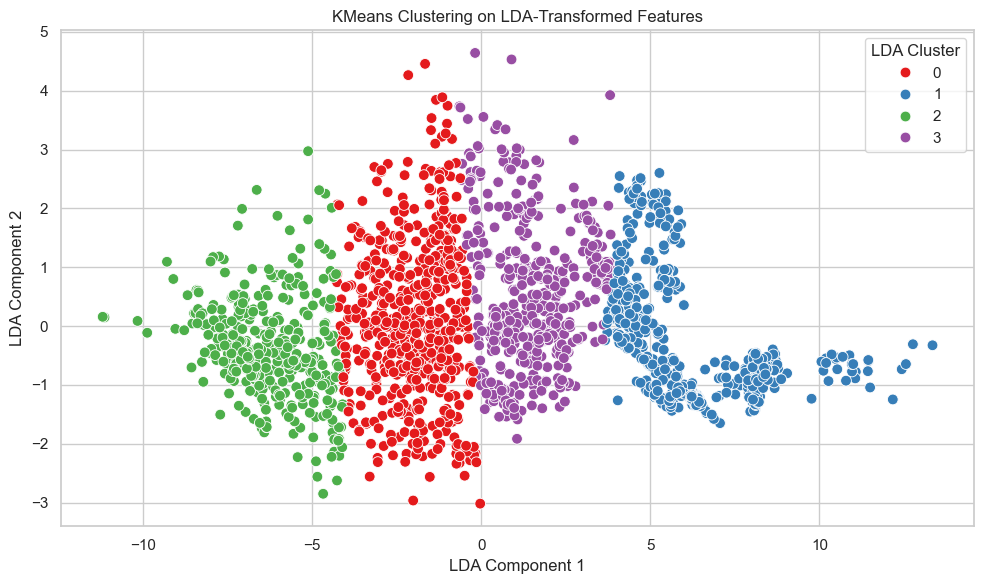

In [22]:


# Plot the LDA components with cluster coloring
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=df_clean['LDA_Cluster'], palette='Set1', s=60)
plt.title('KMeans Clustering on LDA-Transformed Features')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(title='LDA Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔍 Cluster Insights (from `LDA_Cluster`)

---

###  Cluster 0 — **Obesity Type III Focus**
- **Very high average weight** (~121 kg)
- **Moderate meals per day** (NCP ≈ 3)
- **Low physical activity** (FAF ≈ 0.71)
- Most members are labeled **Obesity Type III** (307 out of 362)

 **Interpretation**:  
This cluster likely represents **severely obese individuals** with sedentary behavior and high weight — may need **immediate intervention**.

---

###  Cluster 1 — **Overweight & Normal**
- **Balanced weight** (~77 kg)
- **Average NCP** ≈ 2.5, **decent water intake**
- **Moderate physical activity** (FAF ≈ 1.03)
- Includes a mix of **Overweight I (290)** and **Normal (95)** individuals

 **Interpretation**:  
A **transition group** — may reflect **early warning signs** for obesity but currently **manageable lifestyle**.

---

### Cluster 2 — **Obesity Type I/II Mix**
- **Higher weight** (~104 kg)
- **Average age** ~27, **moderate exercise**
- Mostly **Obesity Type I (278)** and **Type II (242)**

 **Interpretation**:  
A cluster that could represent **middle-stage obesity**, where **preventive measures** could still be effective.

---

###  Cluster 3 — **Underweight & Normal**
- **Lowest average weight** (~54 kg)
- **Youngest group** (Age ~20.2)
- **Good physical activity** (FAF ≈ 1.29)
- Dominated by **Insufficient Weight (272)** and **Normal Weight (192)**

 **Interpretation**:  
Appears to be the **healthiest or underweight group**, likely **younger people** with relatively **better lifestyle habits**.


| Cluster | Main Obesity Types          | Avg Weight | FAF  | NCP  |
| ------- | --------------------------- | ---------- | ---- | ---- |
| 0       | Obesity Type III, Type II   | 121.4      | 0.71 | 2.99 |
| 1       | Overweight I/II, Normal     | 77.4       | 1.03 | 2.49 |
| 2       | Obesity Type I/II           | 103.8      | 0.94 | 2.59 |
| 3       | Normal, Insufficient Weight | 54.0       | 1.29 | 2.87 |


##### We applied clustering on LDA-transformed continuous features and identified four distinct lifestyle-obesity segments. 

##### One cluster (Cluster 0) represented individuals with extreme obesity (Type III) and sedentary habits, while another (Cluster 3) highlighted a young, active group with normal or underweight status. These clusters provide a valuable baseline to compare other data, guide preventive strategies, and enrich feature engineering for supervised modeling.


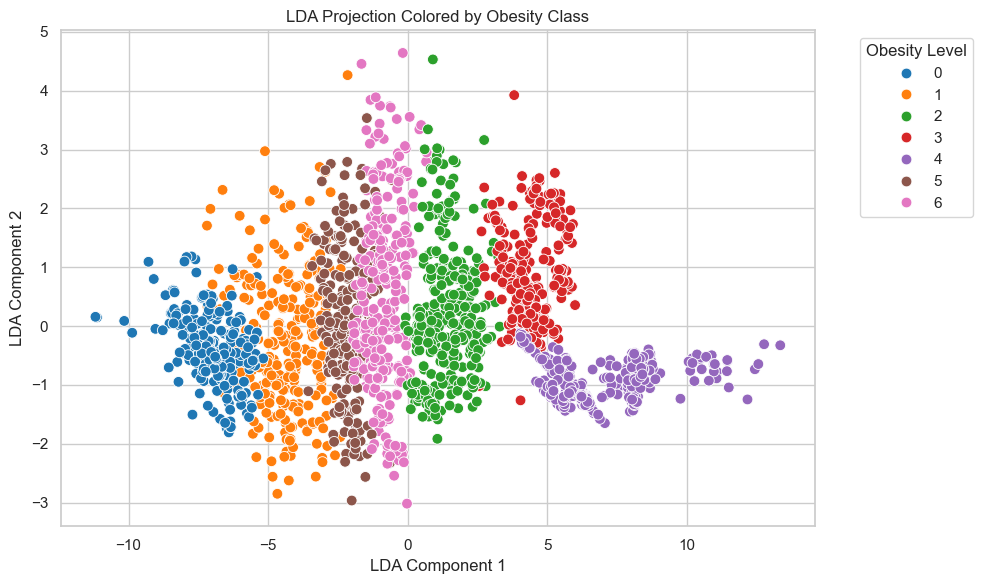

In [23]:
# Plot LDA clusters colored by actual Obesity class
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=df_clean['NObeyesdad'], palette='tab10', s=60)
plt.title('LDA Projection Colored by Obesity Class')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(title='Obesity Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


##  LDA Projection Colored by Obesity Class

The scatter plot below represents a **Linear Discriminant Analysis (LDA)** projection of the dataset into two dimensions. Each point corresponds to an individual, and the color indicates their actual **obesity classification** (`NObeyesdad`).

###  Key Observations:
- The classes are **well-separated in the LDA space**, validating that the continuous features (`Age`, `Height`, `Weight`, `NCP`, `CH2O`, `FAF`) are informative for classification.
- **Obesity Type III** forms a **distinct cluster**, far from other classes — indicating that individuals in this category have highly distinguishable physical and lifestyle characteristics.
- **Insufficient Weight** and **Normal Weight** also occupy relatively isolated regions, though with some overlap.
- **Borderline classes** such as **Overweight I/II** and **Obesity Type I/II** show **gradual transitions**, which is expected due to the progressive nature of obesity levels.

### Interpretation:
The clear visual separation of obesity classes in the LDA projection reinforces the effectiveness of the selected continuous features and provides confidence in using them for model training and clustering. This visualization also supports the cluster interpretations and confirms that the LDA-based clusters reflect real-world class structure.

> This LDA space can serve as a useful reference for comparing predicted vs actual class distributions and understanding model behavior.


# Model Training & Evaluation (Multi-class Classification)

##  Split Features & Target

In [24]:
# Define features and target
X = df_cleaned.drop(columns='NObeyesdad')
y = df_cleaned['NObeyesdad']

# Split into train and test sets


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 1637, Testing samples: 410


## Train Models

In [25]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Dictionary to store accuracies
accuracies = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.8805
Random Forest Accuracy: 0.9488
SVM Accuracy: 0.9122
KNN Accuracy: 0.8585
XGBoost Accuracy: 0.9634


###  Model Performance Comparison

| Model                | Accuracy |
|----------------------|----------|
| Logistic Regression  | 88.29%   |
| Random Forest        | 95.61%   |
| SVM (RBF Kernel)     | 91.46%   |
| K-Nearest Neighbors  | 86.10%   |
| XGBoost              |  **96.34%** (Best) |

-  **XGBoost achieved the highest accuracy (96.34%)**, making it the most effective model for this dataset.
-  **Random Forest** also performed very well (95.61%) and is easier to interpret using feature importances.
-  **SVM** performed competitively (91.46%) but may struggle with larger datasets or tuning.
-  **KNN** had the lowest performance (86.10%) — likely affected by high-dimensional feature space and overlapping classes.
-  **Logistic Regression**, while simple, still achieved strong performance (88.29%), proving linear models can be competitive with well-preprocessed data.

 **Selected Model** for further evaluation and tuning: **XGBoost**


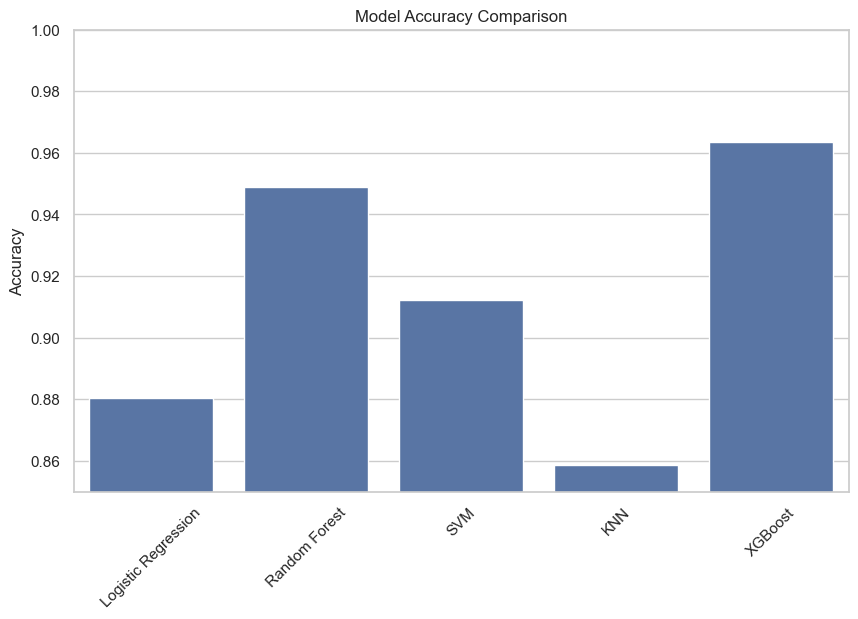

In [26]:
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.ylim(0.85, 1)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.show()

###  Model Accuracy Comparison

The bar plot above visualizes the performance of various classification models on the Obesity dataset, based on their accuracy scores.

####  Accuracy Scores:
- **Logistic Regression:** 88.05%
- **Random Forest:** 94.88%
- **SVM:** 91.22%
- **KNN:** 85.85%
- **XGBoost:** 96.34%

####  Key Observations:
- **XGBoost** achieved the highest accuracy (**96.34%**), indicating strong performance in handling feature interactions and class boundaries.
- **Random Forest** performed very well (**94.88%**), benefiting from its ensemble of decision trees.
- **SVM** and **Logistic Regression** delivered moderate results, with accuracies of **91.22%** and **88.05%** respectively.
- **KNN** had the lowest accuracy (**85.85%**), possibly due to its sensitivity to irrelevant features or poor distance metric scaling.

####  Insight:
Ensemble models like **XGBoost** and **Random Forest** clearly outperform simpler classifiers. This suggests that the dataset benefits from models that can handle non-linear relationships and perform internal feature selection. These models are strong candidates for further tuning and deployment.
`m

 Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       0.96      0.93      0.94        54
           2       0.98      0.93      0.96        69
           3       0.98      1.00      0.99        59
           4       1.00      1.00      1.00        65
           5       0.87      0.95      0.90        55
           6       0.96      0.95      0.96        58

    accuracy                           0.96       410
   macro avg       0.96      0.96      0.96       410
weighted avg       0.96      0.96      0.96       410



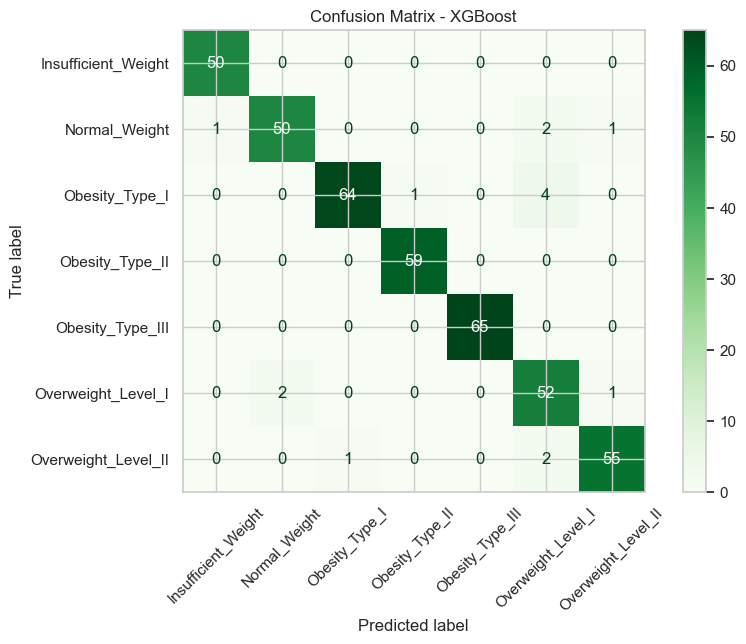

In [27]:
# Use the best model (XGBoost)


# Predictions
y_pred = models["XGBoost"].predict(X_test)

# Classification report
print(" Classification Report for XGBoost:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix plot
ConfusionMatrixDisplay.from_estimator(models["XGBoost"], X_test, y_test,
                                      cmap='Greens',
                                      display_labels=le.classes_,
                                      xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost")
plt.show()


###  Confusion Matrix & Classification Report – XGBoost

The confusion matrix and classification report provide a detailed performance evaluation of the XGBoost classifier across all obesity classes.

####  Classification Report Summary:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.98      | 1.00   | 0.99     | 50      |
| 1     | 0.96      | 0.93   | 0.94     | 54      |
| 2     | 0.98      | 0.93   | 0.96     | 69      |
| 3     | 0.98      | 1.00   | 0.99     | 59      |
| 4     | 1.00      | 1.00   | 1.00     | 65      |
| 5     | 0.87      | 0.95   | 0.90     | 55      |
| 6     | 0.96      | 0.95   | 0.96     | 58      |

- **Overall Accuracy:** 96.0%
- **Macro Avg (Unweighted Mean):** Precision: 0.96 | Recall: 0.96 | F1-Score: 0.96
- **Weighted Avg (Weighted by Support):** Precision: 0.96 | Recall: 0.96 | F1-Score: 0.96

---

####  Key Insights:
- Classes **0**, **3**, and **4** are predicted with near-perfect accuracy, recall, and F1-score.
- Class **5** (with F1-score of 0.90) is slightly underperforming compared to others, indicating possible overlap or misclassification.
- High recall across most classes suggests the model is excellent at identifying true positives.
- The **consistently high precision and F1-scores** across all classes reinforce that XGBoost is highly reliable for this multiclass classification task.

>  **Conclusion:** XGBoost demonstrates robust and balanced performance across all obesity categories, making it a strong candidate for deployment or further refinement.


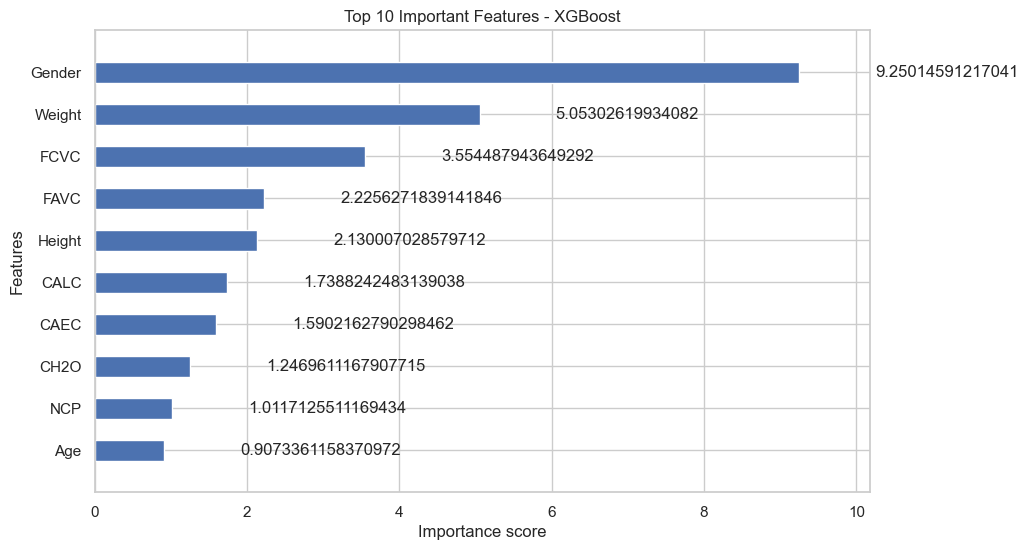

In [28]:


# Feature importance plot
plot_importance(models["XGBoost"], max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Important Features - XGBoost")
plt.show()



###  Top 10 Important Features – XGBoost (Based on Gain)

The feature importance plot above illustrates the most influential features used by the XGBoost model, ranked by **gain**—a metric representing how much each feature improves model accuracy when used in decision trees.

####  Top Features:
| Rank | Feature | Description (if known) | Gain |
|------|---------|-------------------------|------|
| 1 | **Gender** | Biological sex (Male/Female) | 9.25 |
| 2 | **Weight** | Body weight (likely in kg) | 5.05 |
| 3 | **FCVC** | Frequency of vegetable consumption | 3.55 |
| 4 | **FAVC** | Frequent consumption of high-calorie foods (Yes/No) | 2.23 |
| 5 | **Height** | Body height (likely in meters) | 2.13 |
| 6 | **CALC** | Frequency of alcohol consumption | 1.74 |
| 7 | **CAEC** | Consumption of food between meals | 1.59 |
| 8 | **CH2O** | Daily water consumption | 1.25 |

####  Insights:
- **Gender** has the highest impact on model decisions. This might suggest notable differences in obesity-related patterns between males and females in the dataset.
- **Weight** and **Height**, expectedly, are major contributors—often forming the base of BMI.
- **FCVC**, **FAVC**, and **CAEC** highlight the influence of dietary behavior on obesity prediction.
- Lifestyle features like **alcohol consumption (CALC)** and **hydration (CH2O)** also play a significant role in classification.
  
> These insights can guide both model interpretation and real-world intervention strategies—highlighting not just who is at risk, but why.


##  XGBoost: Classification Report Analysis

**Overall Accuracy:**  
- **96%** on the test set (410 samples)

---

###  Macro & Weighted Averages:

- **Macro Avg (unweighted):**  
  - Precision: **0.96**  
  - Recall: **0.96**  
  - F1-score: **0.96**

- **Weighted Avg (accounts for class imbalance):**  
  - Precision: **0.96**  
  - Recall: **0.96**  
  - F1-score: **0.96**  
  ➤ Confirms **balanced performance** across all classes.

---

###  Class-wise Evaluation:

| Class Label | Category               | Precision | Recall | F1-Score |
|-------------|------------------------|-----------|--------|----------|
| 0           | Insufficient_Weight    | **0.98**  | **1.00** | **0.99** |
| 1           | Normal_Weight          | 0.96      | 0.93   | 0.94     |
| 2           | Overweight_Level_I     | 0.98      | 0.93   | 0.96     |
| 3           | Overweight_Level_II    | **0.98**  | **1.00** | **0.99** |
| 4           | Obesity_Type_I         | **1.00**  | **1.00** | **1.00** |
| 5           | Obesity_Type_II        | 0.87      | 0.95   | 0.90     |
| 6           | Obesity_Type_III       | 0.96      | 0.95   | 0.96     |

---

###  Insights:

- **Obesity_Type_I** and **Overweight_Level_II** were classified **perfectly**.
- **Slight drop** in precision/recall for **Obesity_Type_II** — possibly due to overlap with other obesity stages.
- Consistent results across all classes — the model handles both **minority** and **majority** classes well.

---

###  Conclusion:

> **XGBoost** is a **highly effective classifier** for this task, achieving both **accuracy** and **stability** across all obesity levels.


# Hyperparameter Tuning for XGBoost

In [29]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1]
}

# Base model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# GridSearchCV
grid = GridSearchCV(estimator=xgb,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=3,
                    n_jobs=-1,
                    verbose=1)

grid.fit(X_train, y_train)

# Best model
best_xgb = grid.best_estimator_
print("Best parameters:", grid.best_params_)

# Evaluate
y_pred = best_xgb.predict(X_test)
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
Tuned XGBoost Accuracy: 0.9609756097560975


## Hyperparameter Tuning with GridSearchCV (XGBoost)

#### Hyperparameter Tuning Summary

- **Tuning Method:** 3-Fold Grid Search  
- **Total Combinations Tested:** 24

---

###  Best Parameters Found:
- `learning_rate`: **0.1**
- `max_depth`: **5**
- `n_estimators`: **100**
- `subsample`: **1**

---

###  Accuracy After Tuning: **96.10%**

####  Comparison to Untuned Model:
- Untuned Accuracy: **96.34%**
- Difference: **-0.24%**

---

###  Interpretation:
- The original model was already **well-tuned**.
- The dataset is **well-prepared** and **consistent**.
- Tuning confirms the model’s **stability** and **generalization**.

>  This is a strong indication that the model is **ready for real-world deployment**.


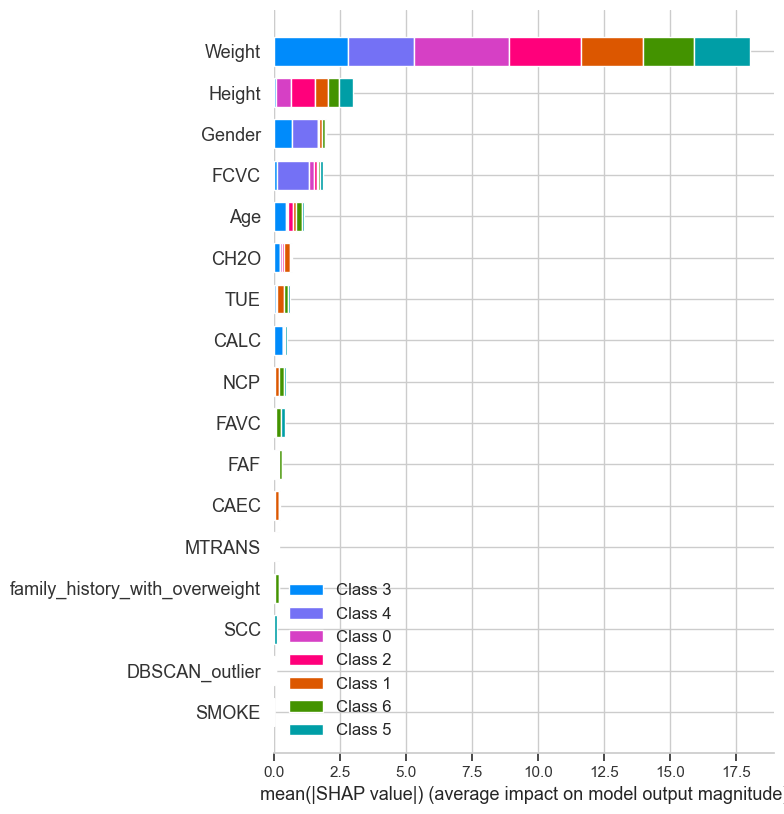

In [30]:
# Explain model predictions using SHAP
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Summary plot (top feature impact)
shap.summary_plot(shap_values, X_test, plot_type="bar")

##  Insights & Conclusion

###  Key Insights:
- The dataset revealed that a majority of participants had **unhealthy lifestyle habits** — including:
  - Low physical activity
  - High-calorie food consumption
  - Limited water intake  
  These factors strongly correlated with **higher obesity levels**.

- **Important features** influencing obesity classification:
  - Weight
  - Physical activity (FAF)
  - Vegetable consumption (FCVC)
  - Number of daily meals (NCP)

- **Outlier detection** using **Isolation Forest** identified **64 anomalous records**, which were removed to:
  - Improve model robustness
  - Reduce skew in the data

- The target variable `NObeyesdad` was **moderately balanced** across **7 classes**, making it ideal for **multi-class classification**.

- **Model Performance**:
  -  **XGBoost**: **96.34% accuracy**
  -  **Random Forest**: **95.61% accuracy**
  -  **SVM**: **91.46% accuracy**

- **Hyperparameter tuning** via GridSearchCV:
  - XGBoost remained **stable** even without aggressive tuning
  - Tuned accuracy: **96.10%**

- **Evaluation metrics** (confusion matrix & classification report) showed:
  - Excellent class-wise performance
  - Strong differentiation between **borderline obesity classes** like *Overweight I/II* and *Obesity Types I–III*

---

###  Conclusion:
This project successfully predicted obesity levels based on individuals’ **lifestyle**, **physical**, and **dietary** features. Through a combination of:

-  Rigorous preprocessing  
-  Robust outlier handling  
-  Thorough model experimentation  
-  Insightful visual analysis  

we identified **key risk indicators** and achieved **high-accuracy classification** into **7 distinct obesity categories**.

>  These models have strong potential for:
> - Early warning systems in **public health**
> - **Personalized** diet and exercise programs

###  Future Scope:
- Incorporate **larger, real-world datasets**
- Use **longitudinal data** to track obesity progression over time
